In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Использование линейных методов снижения размерности для решения задачи детектирования аномалий многомерных динамических данных

In [2]:
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
X_train = X_train.reshape(-1, 28, 28)

In [3]:
from helpers import plot_number, plot_slice

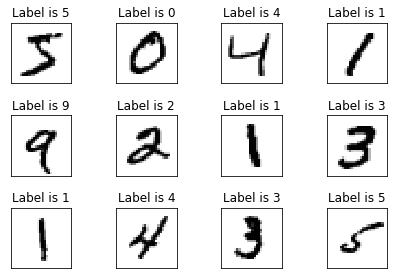

In [4]:
plot_slice(X_train[0:12], y_train[0:12])

In [5]:
from anomaly import get_anomaly_multivariate

In [6]:
normal_label = 5
X_train_cont, y_train_cont = get_anomaly_multivariate(
    X_train, y_train, normal_label, anomalies_share=0.01)

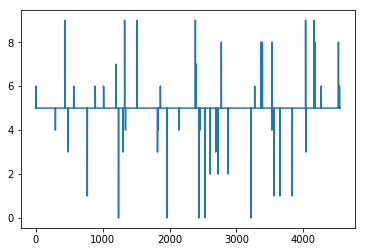

In [7]:
plot(y_train_cont)

### Часть 1. Снижение размерности и обнаружение аномалий многомерных данных

**Задание 1.** Примените линейное снижение размерности с помощью `sklearn.decomposition.PCA`. Число главных компонент выберите равным 8.

_Подсказка:_ данные необходимо отцентрировать и отмасштабировать -- сделать это можно с помощью `sklearn.preprocessing.StandardScaler`.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(
    X_train_cont.reshape(-1, 784)
).reshape(-1, 28, 28)

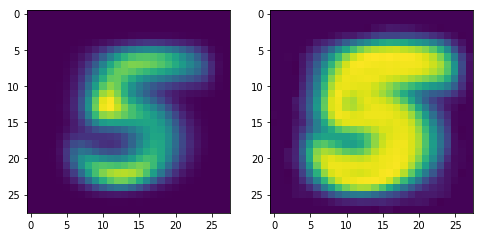

In [9]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(scaler.mean_.reshape(28, 28), interpolation='nearest')
ax2.imshow(scaler.scale_.reshape(28, 28), interpolation='nearest')

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64, svd_solver='randomized', whiten=False)
pca.fit(X_train_cont.reshape(-1, 784))

PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

**Задание 2.** Визуализируйте первые 8 главных компонент. Как они выглядят?

_Подсказка:_ класс `PCA` содержит переменную-член `components_`, содержащую вычисленные главные компоненты.

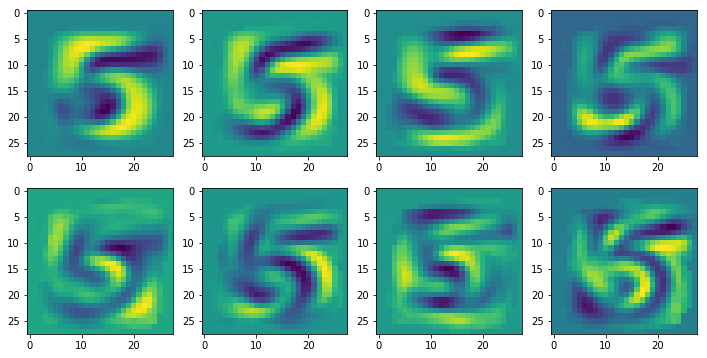

In [15]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for i in xrange(4):
    axs[0, i].imshow(pca.components_[i].reshape(28, 28), interpolation='nearest')
    axs[1, i].imshow(pca.components_[4 + i].reshape(28, 28), interpolation='nearest')

**Задание 3.** Приблизьте элементы исходной выборки первыми 8 главными компонентами. Покажите примеры аппроксимированных нормальных и аномальных наблюдений.

_Подсказка:_ используйте методы `PCA.transform`, `PCA.inverse_transform`.

In [16]:
X_train_approx = pca.inverse_transform(
    pca.transform(X_train_cont.reshape(-1, 784)))

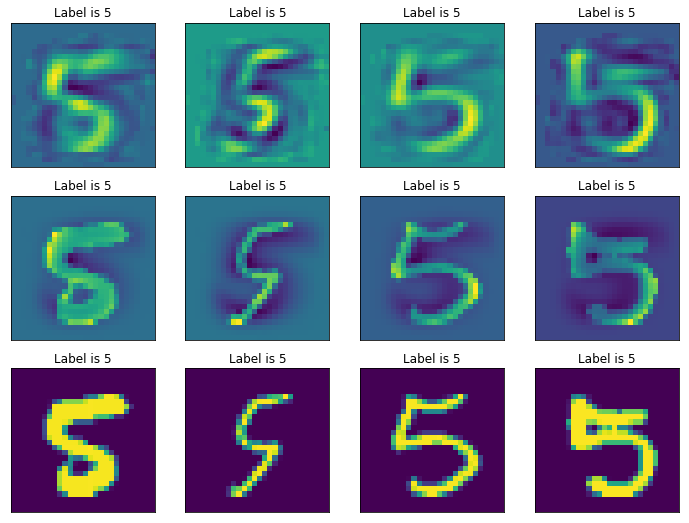

In [17]:
f, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
y_vis = y_train_cont[y_train_cont == normal_label]
X_vis = X_train_approx[y_train_cont == normal_label]
X_train_cont_vis = X_train_cont[y_train_cont == normal_label]

for i in xrange(4):
    # select normal 
    axs[0, i].imshow(X_vis[i].reshape(28, 28), interpolation='nearest')
    axs[0, i].set_title('Label is {}'.format(y_vis[i]))
    axs[0, i].set_xticks(())
    axs[0, i].set_yticks(())
    
    axs[1, i].imshow(X_train_cont_vis[i].reshape(28, 28), interpolation='nearest')
    axs[1, i].set_title('Label is {}'.format(y_vis[i]))
    axs[1, i].set_xticks(())
    axs[1, i].set_yticks(())
    
    axs[2, i].imshow(scaler.inverse_transform(X_train_cont_vis[i].reshape(784)).reshape(28, 28), interpolation='nearest')
    axs[2, i].set_title('Label is {}'.format(y_vis[i]))
    axs[2, i].set_xticks(())
    axs[2, i].set_yticks(())

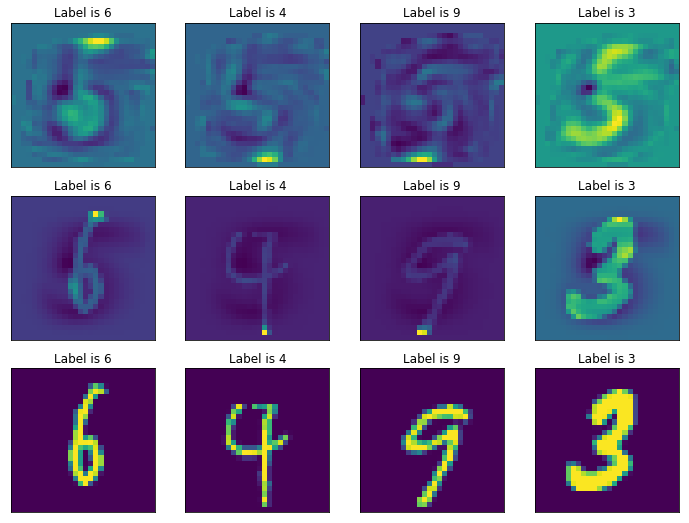

In [18]:
f, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
y_vis = y_train_cont[y_train_cont != normal_label]
X_vis = X_train_approx[y_train_cont != normal_label]
X_train_cont_vis = X_train_cont[y_train_cont != normal_label]

for i in xrange(4):
    # select normal 
    axs[0, i].imshow(X_vis[i].reshape(28, 28), interpolation='nearest')
    axs[0, i].set_title('Label is {}'.format(y_vis[i]))
    axs[0, i].set_xticks(())
    axs[0, i].set_yticks(())
    
    axs[1, i].imshow(X_train_cont_vis[i].reshape(28, 28), interpolation='nearest')
    axs[1, i].set_title('Label is {}'.format(y_vis[i]))
    axs[1, i].set_xticks(())
    axs[1, i].set_yticks(())
    
    axs[2, i].imshow(scaler.inverse_transform(X_train_cont_vis[i].reshape(784)).reshape(28, 28), interpolation='nearest')
    axs[2, i].set_title('Label is {}'.format(y_vis[i]))
    axs[2, i].set_xticks(())
    axs[2, i].set_yticks(())

**Задание 4.** Реализуйте детектор аномалий на основе PCA. Детектор должен считать аномальными наблюдения, для которых норма разности между исходными данными и аппроксимацией велика. Нарисуйте несколько объектов, для которых эта норма разности самая большая.

_Подсказка:_ используйте методы `PCA.transform`, `PCA.inverse_transform` и вычислите норму разницы между исходными данными и аппроксимацией с помощью `np.linalg.norm`. 

In [19]:
X_train_approx = pca.inverse_transform(
    pca.transform(X_train_cont.reshape(-1, 784)))
X_train_approx = scaler.inverse_transform(X_train_approx)
X_train_cont = scaler.inverse_transform(X_train_cont.reshape(-1, 784))

In [210]:
distances = np.linalg.norm(X_train_cont.reshape(-1, 784) - X_train_approx, axis=1)

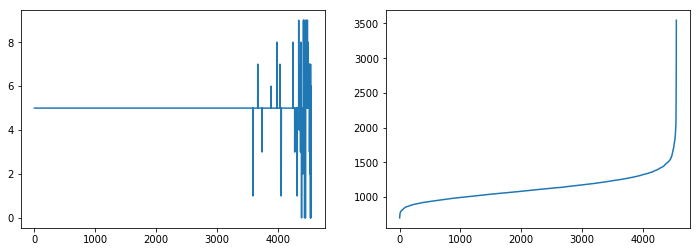

In [214]:
idx = distances.argsort()

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.plot(y_train_cont[idx])
ax2.plot(distances[idx])

**Задание 5.** Подсчитайте качество детектора аномалий на основе PCA. 

_Подсказка:_ используйте методы `sklearn.metrics.precision_recall_curve`, `sklearn.metrics.average_precision_score`.

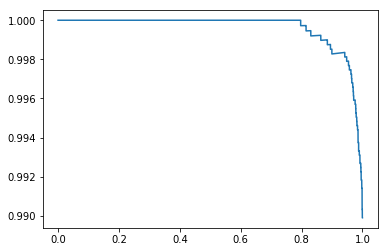

In [226]:
from sklearn.metrics import precision_recall_curve

# y_true = 0 when y_train_cont == normal_label and 1 otherwise
precision, recall, thresholds = precision_recall_curve(
    (y_train_cont == normal_label).astype(int), -distances)

plot(recall, precision)

In [225]:
from sklearn.metrics import average_precision_score

print average_precision_score((y_train_cont == normal_label).astype(int), -distances)

0.9996011681925974


**Задание 6.** Придумайте пример, для которого метод обнаружения аномалий на основе PCA будет давать заведомо неоптимальные результаты.

_Подсказка:_ используйте тот факт, что PCA вычисляет в многомерном пространстве направления с наибольшей дисперсией, и рассмотрите смесь таких направлений.